# Analyse des indicateurs climatiques extrêmes

## 📚 Sommaire

- [📝 Introduction au projet](#introduction)
- [⚙️ Import des bibliothèques et configuration](#imports)
- [📥 Téléchargement automatique des fichiers climatiques NetCDF](#telechargement)
- [📅 Organisation des scénarios et des périodes temporelles](#scenarios)
- [🌙☀️ Fonctions de calcul des indicateurs climatiques](#fonctions)
- [🧮 Calcul des indicateurs par scénario](#calcul-indicateurs)
- [📊 Visualisation des indicateurs](#visualisation)
- [💾 Fusion des scénarios et export CSV](#export-csv)


### 📝 Introduction <a id="introduction"></a>

**📝 Contexte et objectif**

Ce notebook a pour objectif de calculer et visualiser des indicateurs climatiques extrêmes à l’échelle de la France métropolitaine à partir de scénarios climatiques.

Les indicateurs produits incluent :

- Nuits tropicales : nombre de jours où la température minimale dépasse 20 °C.

- Vagues de chaleur : nombre de jours consécutifs (≥ 3) où la température minimale et/ou maximale dépasse des seuils donnés (20 °C pour les min, 35 °C pour les max).

L’objectif principal est de créer un jeu de données prêt à l’analyse pour :

- l’étude de la vulnérabilité climatique,

- l’intégration avec les projections démographiques (comme dans le notebook précédent),

- la cartographie et la visualisation des extrêmes climatiques futurs selon différents scénarios.

**📂 Sources des données**

- Données climatiques journalières (2015‑2100) : issues du SocleM Climat 2025 de Météo-France / DRIAS, sous forme de fichiers NetCDF.

    - Variables : tasAdjust (température moyenne), tasminAdjust (min), tasmaxAdjust (max).

    - Scénarios : RCP 3.7 (SSP370), modèle global CNRM-ESM2-1, modèle régional CNRM-AROME46t1.

    - Zone : France métropolitaine, domaine ALPX-3.

- Références techniques : SocleM Climat 2025, Météo-France / DRIAS
.

**🔍 Méthodologie**  

**1️⃣ Préparation des données**

- Définition des chemins (DATA_FOLDER) et import des packages Python essentiels (xarray, pandas, matplotlib).

- Configuration des warnings pour un affichage propre.

**2️⃣ Téléchargement des fichiers climatiques**

- Boucle sur les variables (tasAdjust, tasminAdjust, tasmaxAdjust) et années.

- Construction automatique du nom de fichier et de l’URL de téléchargement.

- Téléchargement si le fichier n’existe pas déjà localement.

*Commentaire* : le code gère automatiquement les fichiers manquants et évite de re-télécharger des fichiers existants.

**3️⃣ Organisation des scénarios**

- Définition des périodes pour chaque scénario : today (2015‑2035), 2 (2042‑2061), 2.7 (2068‑2087).

- Listing des fichiers NetCDF correspondants pour chaque scénario et variable.

*Commentaire* : cette organisation permet un traitement automatisé par scénario et facilite la répétabilité.

**4️⃣ Fonctions pour calculer les indicateurs**

- Nuits tropicales (return_tropical_nights) : calcule le nombre annuel de nuits avec tasminAdjust > seuil.

- Vagues de chaleur simples (return_threshold_waves) : nombre de jours consécutifs ≥ 3 avec la température au-dessus d’un seuil.

- Vagues de chaleur combinées (return_heatwaves) : prend en compte les seuils minimum et maximum simultanément.

*Commentaire* : toutes les fonctions utilisent xarray pour un traitement vectorisé et efficace des données NetCDF.

**5️⃣ Calcul des indicateurs pour chaque scénario**

- Boucle sur chaque scénario et sur les fichiers journaliers correspondants.

- Calcul des indicateurs :

    - n_tropical_nights_min20

    - n_heatwaves_days_max35

    - n_heatwaves_days_min20

    - n_heatwaves_days_min20_max35

- Agrégation annuelle puis sélection du maximum annuel pour chaque point géographique.

- Export au format NetCDF dans clean_output.

*Commentaire* : le traitement est entièrement vectorisé et robuste, permettant de générer un fichier NetCDF par scénario prêt pour l’analyse spatiale ou la fusion avec d’autres données.

**6️⃣ Visualisation**

- Lecture d’un scénario (scenario_2.7.nc) et génération de graphiques pour chaque variable.

- Organisation en sous-grilles (subplot) pour comparer visuellement les différents indicateurs.

*Commentaire* : cette étape permet un contrôle visuel rapide et intuitif des indicateurs calculés avant toute analyse plus fine.

**7️⃣ Export vers CSV pour fusion et analyse**

- Conversion des fichiers NetCDF en DataFrames pandas.

- Fusion des différents scénarios (today, 2, 2.7) en un jeu de données unique.

- Export final au format CSV avec timestamp pour traçabilité.

*Commentaire* : le format CSV final facilite l’intégration avec d’autres bases de données (par exemple les projections démographiques du notebook précédent).

**⚠️ Limites**

- Spatialisation : les données sont sur une grille régulière, pas directement corrélées à des limites administratives ou zones peuplées.

- Seuils fixes : les indicateurs extrêmes sont calculés avec des seuils constants (20 °C pour min, 35 °C pour max). D’autres définitions pourraient être explorées.

- Scénarios climatiques : basés sur un seul GCM et RCM, et un seul SSP, ce qui ne reflète pas toute l’incertitude climatique.

- Longueur des périodes : certaines périodes courtes peuvent ne pas capturer la variabilité interannuelle complète.

### ⚙️ Import des bibliothèques et configuration <a id="imports"></a>

In [1]:
from pathlib import Path
import pandas as pd
import requests
import xarray as xr
import matplotlib.pyplot as plt
import time

DATA_FOLDER = Path(r"C:\Users\Utilisateur\Documents\HAI\06_hackathon_meteo_france\data")
import warnings
warnings.filterwarnings("ignore")

### 📥 Téléchargement automatique des fichiers climatiques NetCDF<a id="telechargement"></a>


**Objectif de la section :**   

Télécharger automatiquement les fichiers de données climatiques journalières fournis par Météo-France / DRIAS pour différents scénarios et périodes.  
 Ces fichiers contiennent les températures ajustées (tasAdjust, tasminAdjust, tasmaxAdjust) pour la métropole française, afin d’alimenter les analyses ultérieures de vagues de chaleur et de nuits tropicales.

In [ ]:

# URL de base pour accéder aux données climatiques SocleM-Climat 2025
base_url = "https://object.files.data.gouv.fr/meteofrance-drias/SocleM-Climat-2025" 

# Paramètres de téléchargement et d’organisation des fichiers
type_downscaling = "CPRCM"           # Type de descente d’échelle (regional climate model)
zone = "METROPOLE"                   # Zone géographique (France métropolitaine)
domain = "ALPX-3"                     # Domaine régional spécifique (modèle ALPX-3)
gcm = "CNRM-ESM2-1"                   # Modèle climatique global (Global Climate Model)
member = "r1i1p1f2"                   # Réalisation du modèle
rcm = "CNRM-AROME46t1"                # Modèle régional utilisé pour la descente d’échelle
ssp = "ssp370"                         # Scénario socio-économique (RCP / SSP)
timestep = "day"                       # Pas temporel : données journalières
variable = "tasAdjust"                 # Variable climatique principale (température moyenne journalière)
version = "version-hackathon-102025"  # Version des fichiers fournie pour le hackathon



# Boucle sur les variables de température : moyenne, min, max
for variable in ["tasAdjust", "tasminAdjust", "tasmaxAdjust"]:
    # Boucle sur les périodes à télécharger : 2015-2019, 2100, puis toutes les décennies 2020-2099
    for year1,year2 in [(2015, 2019), (2100,2100)] + [(y*10, y*10+9) for y in range(202, 210)]:
        
        # Construction du nom de fichier selon la convention Météo-France / DRIAS
        filename = f"{variable}_FR-Metro_{gcm}_{ssp}_{member}_CNRM-MF_{rcm}_v1-r1_MF-CDFt-ANASTASIA-{domain}-1991-2020_day_{year1}0101-{year2}1231.nc"
        
        # Construction de l'URL complète de téléchargement
        url = f"{base_url}/{type_downscaling}/{zone}/{domain}/{gcm}/{member}/{rcm}/{ssp}/{timestep}/{variable}/{version}/{filename}"
        
        # Chemin local de sauvegarde
        output_path = DATA_FOLDER / "climate_data" / filename

        # Téléchargement uniquement si le fichier n’existe pas déjà
        if not output_path.exists():
            r = requests.get(url)
            # Écriture du fichier par morceaux pour gérer de gros fichiers
            with open(output_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)


"CNRM-ESM2-1" ssp370  r1i1p1f2 CNRM-AROME46t1

scenario +2 2052 [2042, 2061]
scenario +2,7 2078 [2069, 2088]

### 📅 Organisation des scénarios et des périodes temporelles<a id="scenarios"></a>

Ce bloc définit les **scénarios climatiques** et organise les fichiers de données correspondants pour la métropole française.

**Scénarios considérés :**

- "today" : situation actuelle / proche futur (2015‑2035)

- 2 : scénario futur modéré (~+2°C) (2042‑2061)

- 2.7 : scénario plus chaud (~+2.7°C) (2068‑2087)

**Variables climatiques incluses :**

- tasAdjust : température moyenne journalière ajustée

- tasminAdjust : température minimale journalière ajustée

- tasmaxAdjust : température maximale journalière ajustée

**Organisation des fichiers :**

- Chaque scénario contient une liste de fichiers NetCDF pour les températures minimales (min) et maximales (max)

- Chaque liste regroupe plusieurs fichiers couvrant des périodes successives (ex. 2015‑2019, 2020‑2029, …)

- Cette structure permet de parcourir automatiquement les fichiers pour calculer les indicateurs climatiques (nuits tropicales, vagues de chaleur)

**💡 But** : faciliter la lecture, l’agrégation et le traitement des données climatiques par scénario et par période, tout en gardant la flexibilité pour ajouter d’autres variables ou scénarios à l’avenir.


In [ ]:

scenario_years = {
    "today": (2015,2035),
    2: (2042, 2061),
    2.7: (2068, 2087),
}

scenario_data = {
    "today": {
        "min": [
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20150101-20191231.nc",
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20200101-20291231.nc",
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20300101-20391231.nc",
        ],
        "max": [
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20150101-20191231.nc",
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20200101-20291231.nc",
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20300101-20391231.nc",
        ]
    },
    2: {
        "min": [
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20400101-20491231.nc",
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20500101-20591231.nc",
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20600101-20691231.nc"
        ],
        "max": [
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20400101-20491231.nc",
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20500101-20591231.nc",
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20600101-20691231.nc"
        ]
    },
    2.7: {
        "min": [
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20600101-20691231.nc",
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20700101-20791231.nc",
            "tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20800101-20891231.nc"
        ],
        "max": [
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20600101-20691231.nc",
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20700101-20791231.nc",
            "tasmaxAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20800101-20891231.nc"
        ]
    }
}

### 🌙☀️ Fonctions de calcul des indicateurs climatiques<a id="fonctions"></a>

**🌡️ Introduction aux indicateurs climatiques : nuits tropicales et vagues de chaleur**

Dans cette section, nous calculons des indicateurs climatiques essentiels pour l’évaluation des impacts du réchauffement : les nuits tropicales et les vagues de chaleur.

Le code exploite des fichiers NetCDF journaliers de températures minimales et maximales pour la France métropolitaine, issus des projections climatiques DRIAS-Météo France. Chaque indicateur est calculé année par année, afin de suivre l’évolution temporelle des conditions extrêmes.

**Les indicateurs principaux sont :**

- **Nuits tropicales** : nombre de nuits où la température minimale dépasse un seuil donné (en °C).

- **Vagues de chaleur basées sur une variable** : nombre de jours par année où la température minimale ou maximale dépasse un seuil sur au moins 3 jours consécutifs.

- **Vagues de chaleur combinées** : nombre de jours par année où la température minimale et la température maximale dépassent simultanément leurs seuils respectifs sur 3 jours consécutifs.

Le code est conçu pour être **flexible et reproductible :

- Les seuils de température peuvent être ajustés selon la définition d’une nuit tropicale ou d’une vague de chaleur.

- Les fonctions peuvent travailler soit sur une seule variable (min ou max) soit sur les deux combinées pour une analyse plus stricte.

- Le calcul est effectué par année, facilitant l’agrégation pour des analyses temporelles ou spatiales.

Ainsi, cette section constitue la brique centrale pour la production d’indicateurs climatiques locaux, qui seront ensuite utilisés pour analyser les tendances et comparer différents scénarios de réchauffement.

In [ ]:
import xarray as xr

KELVIN_CONSTANT = 273.15

def return_tropical_nights(data, threshold):
    """
    Calcule le nombre annuel de nuits tropicales à partir d’un fichier NetCDF 
    et d’un seuil de température.

    Une nuit est dite tropicale si la température minimale (tasminAdjust)
    reste au-dessus du seuil (en °C).

    Paramètres :
        data (xarray.Dataset) : Données contenant la variable 'tasminAdjust'.
        threshold (float) : Seuil en °C pour définir une nuit tropicale.

    Retour :
        xarray.DataArray : Nombre annuel de nuits tropicales.
    """
    return (
        data["tasminAdjust"] > threshold + KELVIN_CONSTANT
    ).groupby("time.year").sum(dim="time", skipna=False).rename({"year": "time"})


def return_threshold_waves(threshold, data, variable_name):
    """
    Calcule le nombre annuel de jours de vagues de chaleur à partir d’un seuil
    appliqué soit aux températures minimales, soit aux maximales.

    Une vague de chaleur est définie comme une séquence d’au moins 3 jours consécutifs
    où la température dépasse le seuil donné.

    Paramètres :
        threshold (float) : Seuil en °C.
        data (xarray.Dataset) : Données climatiques (tasminAdjust ou tasmaxAdjust).
        variable_name (str) : Variable à utiliser ('tasminAdjust' ou 'tasmaxAdjust').

    Retour :
        xarray.DataArray : Nombre annuel de jours en vague de chaleur.
    """
    all_years = []
    
    for year in set(data.time.dt.year.values):
        data_year = data.sel(time=data.time.dt.year == year)

        # Condition : jour chaud
        hot = data_year[variable_name] > threshold + KELVIN_CONSTANT
        
        # Rolling de 3 jours pour identifier les séquences chaudes
        rolling_hot = hot.rolling(time=3, center=False).sum()

        # Détection des 3 jours consécutifs (décalages)
        stacked = xr.concat(
            [
                rolling_hot == 3,                 # jour même
                rolling_hot.shift(time=-1) == 3,  # veille
                rolling_hot.shift(time=-2) == 3   # avant-veille
            ],
            dim="window"
        )

        heatwave_days = stacked.any(dim="window")  # au moins une condition vraie
        all_years.append(heatwave_days.sum(dim="time"))
    
    return xr.concat(all_years, dim="time")


def return_heatwaves(data_min, data_max, threshold_min, threshold_max):
    """
    Calcule le nombre annuel de jours de vagues de chaleur en utilisant simultanément :
        - un seuil sur les températures minimales
        - un seuil sur les températures maximales

    Une vague de chaleur se produit si, durant au moins 3 jours consécutifs,
    la température minimale ET la température maximale dépassent leurs seuils respectifs.

    Paramètres :
        data_min (xarray.Dataset) : Données contenant 'tasminAdjust'.
        data_max (xarray.Dataset) : Données contenant 'tasmaxAdjust'.
        threshold_min (float) : Seuil en °C pour les températures minimales.
        threshold_max (float) : Seuil en °C pour les températures maximales.

    Retour :
        xarray.DataArray : Nombre annuel de jours de vagues de chaleur.
    """
    all_years = []

    for year in set(data_min.time.dt.year.values):
        # Fusion des datasets min et max pour l'année
        data_year = xr.merge(
            [
                data_min.sel(time=data_min.time.dt.year == year),
                data_max.sel(time=data_max.time.dt.year == year)
            ],
            join="outer"
        )

        # Condition : jour chaud pour min ET max
        hot = (
            (data_year["tasminAdjust"] > threshold_min + KELVIN_CONSTANT) &
            (data_year["tasmaxAdjust"] > threshold_max + KELVIN_CONSTANT)
        )

        # Rolling de 3 jours
        rolling_hot = hot.rolling(time=3, center=False).sum()

        stacked = xr.concat(
            [
                rolling_hot == 3,
                rolling_hot.shift(time=-1) == 3,
                rolling_hot.shift(time=-2) == 3
            ],
            dim="window"
        )

        heatwave_days = stacked.any(dim="window")
        all_years.append(heatwave_days.sum(dim="time"))

    return xr.concat(all_years, dim="time")


### 🧮 Calcul des indicateurs par scénario<a id="calcul-indicateurs"></a>

**🌡️ Calcul des indicateurs climatiques par scénario**

Dans cette section, nous produisons, pour chaque scénario climatique, une série d’indicateurs annuels basés sur les températures quotidiennes issues des simulations Météo-France.
L’objectif est d’obtenir, pour chaque scénario, un jeu de données NetCDF contenant les valeurs maximales annuelles :

- du nombre de nuits tropicales,

- du nombre de jours de vagues de chaleur selon plusieurs critères,

- du nombre de vagues de chaleur combinant températures minimales et maximales.

Les indicateurs sont construits à partir des fichiers journaliers de température minimale (tasminAdjust) et maximale (tasmaxAdjust).

**1. Boucle principale sur les scénarios**

Pour chaque scénario climatique (ex. SSP126, SSP245…), une boucle lit successivement tous les fichiers de température minimale et maximale correspondant à ce scénario.

Chaque fichier est tronqué temporellement pour ne conserver que la période définie dans scenario_years.

**2. Calcul des nuits tropicales**

Pour chaque fichier de température minimale, on calcule le nombre annuel de nuits tropicales :

- un jour est considéré comme nuit tropicale si tasminAdjust > 20°C (converti en Kelvin),

- les valeurs sont ensuite regroupées par année,

- le résultat produit un indicateur nommé n_tropical_nights_min20.

Chaque fichier contribue un bloc annuel, tous concaténés ensuite.

**3. Calcul des vagues de chaleur basées sur les maximums**

On calcule ensuite les jours appartenant à une vague de chaleur selon le critère :

- ≥ 3 jours consécutifs avec tasmaxAdjust > 35°C.

Une détection par fenêtre glissante (rolling 3 jours) identifie toutes les séquences valides, puis le total annuel est extrait.
Cet indicateur est nommé : n_heatwaves_days_max35.

**4. Calcul des vagues de chaleur basées sur les minimums**

Un second indicateur similaire est produit en utilisant les températures minimales :

- ≥ 3 jours consécutifs avec tasminAdjust > 20°C.

Il produit l'indicateur : n_heatwaves_days_min20.

**5. Vagues de chaleur combinées min + max**

Une troisième famille d’indicateurs repose sur une condition double :

- tasminAdjust > 20°C ET

- tasmaxAdjust > 35°C
pendant au moins 3 jours consécutifs.

Cet indicateur reflète des épisodes intenses et prolongés :
→ n_heatwaves_days_min20_max35

**6. Agrégation : extraire les valeurs maximales**

Pour chaque indicateur généré, on rassemble les séries annuelles issues de tous les fichiers du scénario, puis :

- on concatène tout au long du temps,

- on extrait la valeur maximale observée pour chaque cellule spatiale.

Cela fournit une carte "worst case" par indicateur et par scénario.

**7. Création du fichier final par scénario**

Un masque est appliqué pour conserver uniquement les zones valides (non nulles).
Les indicateurs sont fusionnés dans un seul dataset, puis exportés sous forme de :

➡️ scenario_<nom>.nc

dans le dossier clean_output.

In [ ]:
import xarray as xr

# -------------------------------------------------------------------
# BOUCLE PRINCIPALE SUR LES SCÉNARIOS
# -------------------------------------------------------------------
for scenario, variable_data in scenario_data.items():

    # Dictionnaire contenant : indicateur → liste des valeurs annuelles (3 fichiers par scénario)
    all_indicators = {}

    # -------------------------------------------------------------------
    # BOUCLE SUR LES 3 FICHIERS DE CHAQUE SCÉNARIO (min et max)
    # -------------------------------------------------------------------
    for path_data_min, path_data_max in zip(variable_data["min"], variable_data["max"]):

        # --- Lecture des fichiers NetCDF ---
        data_min = xr.open_dataset(DATA_FOLDER / "climate_data" / path_data_min)
        data_max = xr.open_dataset(DATA_FOLDER / "climate_data" / path_data_max)

        # --- Sélection de la fenêtre temporelle du scénario ---
        start_year, end_year = scenario_years[scenario]
        data_min = data_min.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
        data_max = data_max.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

        # -------------------------------------------------------------------
        # INDICATEUR 1 : Nuits tropicales (tasmin > 20°C)
        # -------------------------------------------------------------------
        for threshold in [20]:
            tropical_nights = return_tropical_nights(
                data=data_min,
                threshold=threshold
            )
            name = f"n_tropical_nights_min{threshold}"
            tropical_nights.name = name
            all_indicators.setdefault(name, []).append(tropical_nights)

        # -------------------------------------------------------------------
        # INDICATEUR 2 : Jours de chaleur ≥ 35°C
        # -------------------------------------------------------------------
        heatwaves_max35 = return_threshold_waves(
            threshold=35,
            data=data_max,
            variable_name="tasmaxAdjust",
        )
        heatwaves_max35.name = "n_heatwaves_days_max35"
        all_indicators.setdefault("n_heatwaves_days_max35", []).append(heatwaves_max35)

        # -------------------------------------------------------------------
        # INDICATEUR 3 : Vagues de chaleur via les températures minimales
        # -------------------------------------------------------------------
        for threshold in [20]:
            heatwaves_min = return_threshold_waves(
                threshold=threshold,
                data=data_min,
                variable_name="tasminAdjust",
            )
            name = f"n_heatwaves_days_min{threshold}"
            heatwaves_min.name = name
            all_indicators.setdefault(name, []).append(heatwaves_min)

        # -------------------------------------------------------------------
        # INDICATEUR 4 : Vagues de chaleur combinées (min > 20°C ET max > 35°C)
        # -------------------------------------------------------------------
        for threshold_min in [20]:
            heatwave_minmax = return_heatwaves(
                data_min=data_min,
                data_max=data_max,
                threshold_min=threshold_min,
                threshold_max=35
            )
            name = f"n_heatwaves_days_min{threshold_min}_max35"
            heatwave_minmax.name = name
            all_indicators.setdefault(name, []).append(heatwave_minmax)

    # -------------------------------------------------------------------
    # POST-TRAITEMENT : On combine les valeurs des 3 fichiers du scénario
    # et on conserve le maximum annuel obtenu parmi eux.
    # -------------------------------------------------------------------
    all_indicators_max = {}
    for key, yearly_values in all_indicators.items():
        all_indicators_max[key] = xr.concat(yearly_values, dim="time").max(dim="time")

    # Fusion dans un dataset final
    final_data = xr.merge(list(all_indicators_max.values()))

    # Application d’un masque (zones sans données)
    mask = data_min["tasminAdjust"].notnull()[0]
    final_data = final_data.where(mask)

    # Sauvegarde NetCDF finale
    final_data.to_netcdf(
        DATA_FOLDER / "clean_output" / f"scenario_{scenario}.nc"
    )


### 📊 Visualisation des indicateurs<a id="visualisation"></a>

**📊 Visualisation des indicateurs climatiques d’un scénario**

Dans cette section, nous produisons une visualisation complète des indicateurs climatiques contenus dans un fichier NetCDF correspondant à un scénario donné.
L’objectif est d’afficher, sous forme de cartes spatiales, l’ensemble des variables calculées pour ce scénario, afin de faciliter l'analyse et la comparaison des résultats.

Chaque variable (ex. : nuits tropicales, jours de vagues de chaleur…) est tracée dans un sous-graphe dédié au sein d’une grille de figures.

**1. Chargement du fichier NetCDF**

Le fichier généré en étape précédente (ex. : scenario_2.7.nc) est ouvert avec xarray :

- il contient toutes les cartes d’indicateurs pour ce scénario,

- chaque variable représente un indicateur agrégé (valeur maximale annuelle).

On récupère la liste complète des variables climatiques à représenter.

**2. Construction automatique de la grille de visualisation**

Afin d’afficher toutes les cartes simultanément :

- le script calcule automatiquement le nombre de lignes et de colonnes nécessaires,

- une figure matplotlib est créée avec un tableau de sous-figures,

- la disposition par défaut utilise 3 colonnes, avec un nombre de lignes ajusté selon le nombre total de variables.

Cette approche garantit une organisation claire et lisible, quel que soit le nombre d’indicateurs.

**3. Tracé des cartes des indicateurs**

Pour chaque variable du dataset :

- une carte spatiale est produite via xarray.plot(),

- le titre du graphe reprend automatiquement le nom de l’indicateur,

- les données sont représentées en utilisant la grille spatiale d’origine (latitude/longitude).

Les sous-figures excédentaires (si la grille est plus grande que nécessaire) sont désactivées pour un rendu propre.

**4. Mise en page finale**

La figure complète est finalisée grâce à :

- tight_layout() pour harmoniser les espacements,

- un affichage standardisé des couleurs et axes selon les paramètres de xarray,

- une visualisation synthétique regroupant l’ensemble des indicateurs.

**🖼️ Résultat**

Cette section produit une figure multi-cartes où chaque indicateur climatique apparaît dans sa propre case :

- nuits tropicales,

- vagues de chaleur selon seuils min et max,

- vagues combinées,

- tout autre indicateur présent dans le NetCDF.

Elle permet d’obtenir d’un seul coup d’œil une vue d’ensemble des impacts climatiques projetés pour le scénario sélectionné.

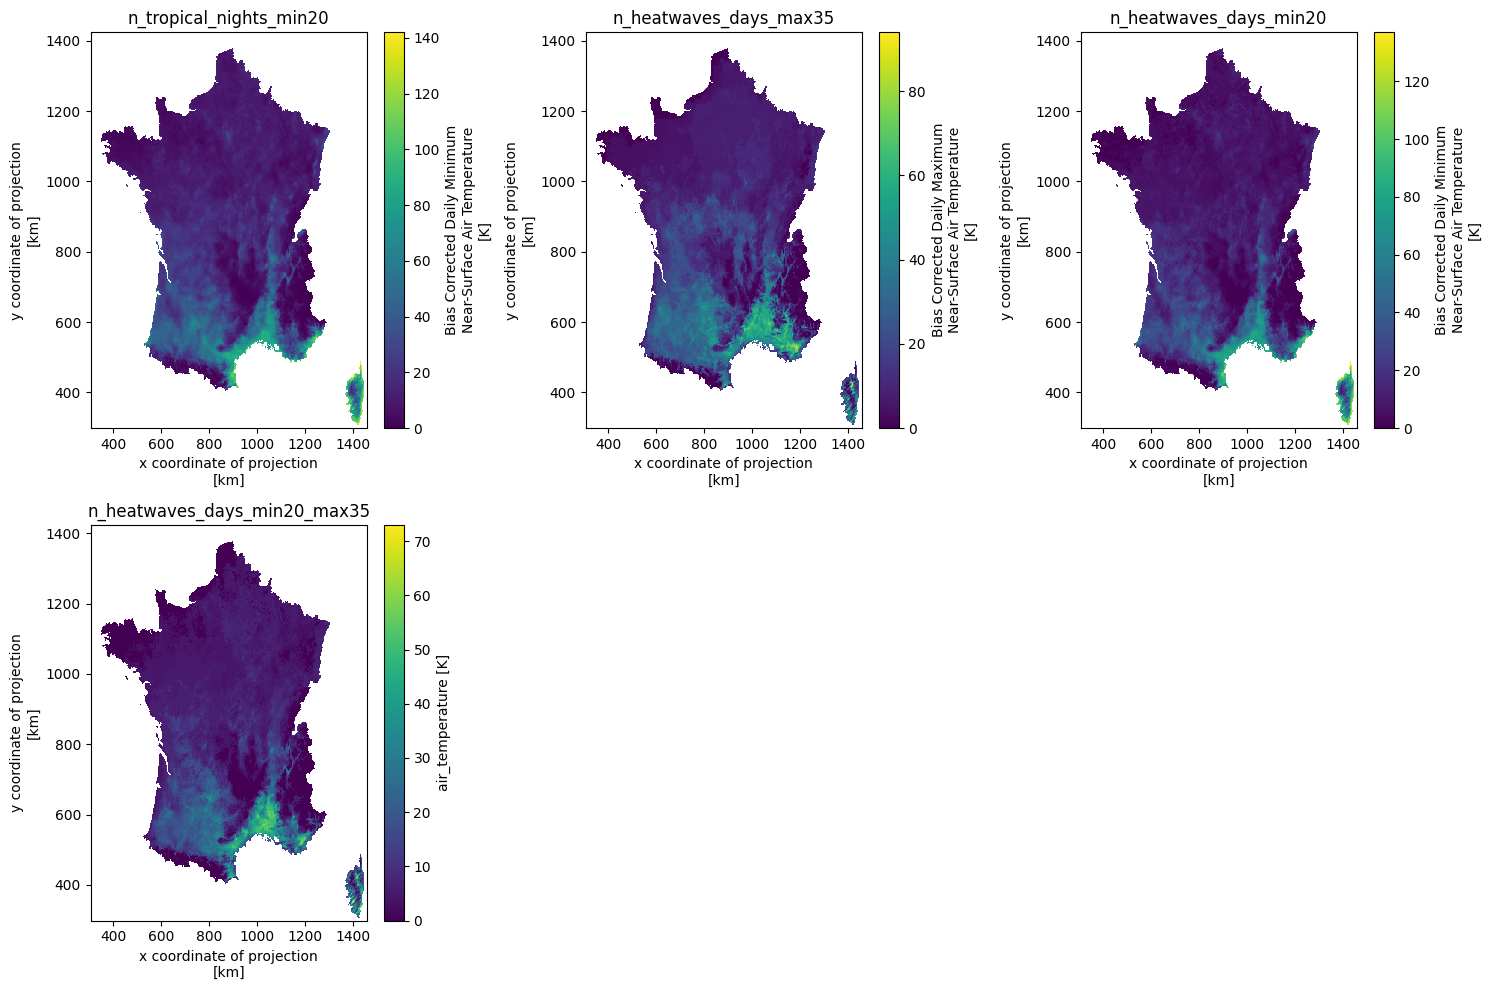

In [ ]:
ds = xr.open_dataset(DATA_FOLDER / "clean_output" / f"scenario_2.7.nc")

# Get list of data variables (excluding coordinates)
data_vars = list(ds.data_vars)

# Create subplots - one for each variable
n_vars = len(data_vars)
n_cols = 3  # Number of columns in subplot grid
n_rows = (n_vars + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_vars > 1 else [axes]

# Plot each variable
for i, var in enumerate(data_vars):
    ds[var].plot(ax=axes[i])
    axes[i].set_title(var)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 💾 Fusion des scénarios et export CSV<a id="export-csv"></a>

**🧩 Fusion des indicateurs climatiques entre scénarios**

Cette section assemble les données climatiques issues des trois scénarios (présent, +2°C, +2.7°C) en un seul fichier consolidé.

**1. Conversion des fichiers NetCDF en DataFrame**

Pour chaque scénario, le fichier NetCDF est :

- ouvert,

- converti en DataFrame,

- allégé des colonnes inutiles (lon, lat, time),

et ses variables sont renommées avec un préfixe spécifique (sc_today_, sc_2_, sc_2.7_) afin d’identifier clairement les indicateurs selon le scénario.

**2. Fusion des scénarios sur la grille spatiale**

Les trois DataFrames sont fusionnés spatialement sur les coordonnées (x, y).
Un filtrage supprime les lignes incomplètes pour ne conserver que les cellules présentes dans tous les scénarios.

**3. Export final**

Le tableau final, contenant tous les indicateurs climatiques pour chaque scénario, est exporté en CSV sous le nom :

climate_data_"timestamp".csv


Il constitue la base de travail pour les analyses et croisements avec les données démographiques.

In [ ]:
# --- Chargement du scénario "today" ---
ds0 = xr.open_dataset(DATA_FOLDER / "clean_output" / f"scenario_today.nc")

# Conversion en DataFrame
df0 = ds0.to_dataframe()

# Suppression des colonnes non pertinentes
df0 = df0.drop(["lon", "lat", "time"], axis=1)

# Renommage des colonnes avec un préfixe indiquant le scénario
df0 = df0.rename(columns={col: f"sc_today_{col}" for col in df0.columns if col not in ["lon", "lat"]})


# --- Chargement du scénario +2°C ---
ds1 = xr.open_dataset(DATA_FOLDER / "clean_output" / f"scenario_2.nc")
df1 = ds1.to_dataframe()
df1 = df1.drop(["lon", "lat", "time"], axis=1)
df1 = df1.rename(columns={col: f"sc_2_{col}" for col in df1.columns if col not in ["lon", "lat"]})


# --- Chargement du scénario +2.7°C ---
ds2 = xr.open_dataset(DATA_FOLDER / "clean_output" / f"scenario_2.7.nc")
df2 = ds2.to_dataframe()

# Pour ce fichier, seules les valeurs "time" sont à retirer
df2 = df2.drop(["time"], axis=1)

# Renommage des colonnes
df2 = df2.rename(columns={col: f"sc_2.7_{col}" for col in df2.columns if col not in ["lon", "lat"]})


# --- Fusion des trois scénarios sur les coordonnées x/y ---
df_final = (
    df0.merge(df1, how="outer", on=["x", "y"])
       .merge(df2, how="outer", on=["x", "y"])
       .dropna(how='any')   # Suppression des lignes incomplètes
)


# --- Export en CSV avec horodatage ---
df_final.to_csv(
    DATA_FOLDER / "clean_output" / f"climate_data_{time.strftime('%Y%m%d-%H%M%S')}.csv"
)


In [36]:
df_final.columns

Index(['sc_today_n_tropical_nights_min20', 'sc_today_n_heatwaves_days_max35',
       'sc_today_n_heatwaves_days_min20',
       'sc_today_n_heatwaves_days_min20_max35', 'sc_2_n_tropical_nights_min20',
       'sc_2_n_heatwaves_days_max35', 'sc_2_n_heatwaves_days_min20',
       'sc_2_n_heatwaves_days_min20_max35', 'sc_2.7_n_tropical_nights_min20',
       'sc_2.7_n_heatwaves_days_max35', 'sc_2.7_n_heatwaves_days_min20',
       'sc_2.7_n_heatwaves_days_min20_max35', 'lon', 'lat'],
      dtype='object')